# Set Up

In [1]:
# Basic imports
import os
import random
import importlib
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data Processing

# Training & Test Split

In [3]:
# Data Preparation
from sklearn.preprocessing import MinMaxScaler
def prepare_data(df, features = ["Price"]):
    # Select the relevant columns
    data = df[features].copy().dropna()

    # Normalize the data
    scaler_dict = {}
    for column in data.columns:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        scaler_dict[column] = scaler
    
    return data, scaler_dict, features

# Create sequences
def create_sequences(data, seq_length, target_column='Price'):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length][target_column]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Evaluation

In [4]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# MAE
def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true)))

# MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [5]:
def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100


In [6]:
def evaluate_model(model, X_test, y_test, price_scaler, target_col=0):
    """
    Evaluate model performance on test data with multiple features.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets (single column)
        scaler: Fitted scaler for inverse transformation
        target_col (int): Index of the target column
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    
    # Inverse transform to get actual values
    y_test_inv = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    pred_inv = price_scaler.inverse_transform(pred).flatten()
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv,
        'pred': pred_inv
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    mse = mean_squared_error(test['actual'], test['pred'])
    rmse = root_mean_squared_error(test['actual'], test['pred'])
    directional_acc = directional_accuracy(test['actual'], test['pred'])
    mae = mean_absolute_error(test['actual'], test['pred'])

    from sklearn.metrics import r2_score
    r2 = r2_score(test['actual'], test['pred'])
    
    return test, mape, mse, rmse, directional_acc, r2, mae

In [7]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [8]:
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# Run

# Hyperparameter Tuning

In [9]:
def build_tunable_model(hp, input_shape):
    """
    Build a model with tunable hyperparameters.
    
    Parameters:
        hp: Hyperparameter object from Keras Tuner
        input_shape: Shape of input data
        
    Returns:
        Model: Compiled LSTM model with tunable parameters
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # Tune number of LSTM layers: 1 to 3
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3)

    for i in range(num_layers):
        units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32)
        return_sequences = True if i < num_layers - 1 else False
        model.add(LSTM(units=units, return_sequences=return_sequences))

    
    # Tune dense layer units
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    
    # Tune L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')
    model.add(Dense(dense_units, kernel_regularizer=regularizers.L2(l2_reg)))
    
    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError()])
    #try 
    return model

In [10]:
def tune_hyperparameters(X_train, y_train, input_shape, max_trials=10):
    """
    Perform hyperparameter tuning using Keras Tuner.
    
    Parameters:
        X_train: Training features
        y_train: Training targets
        input_shape: Shape of input data
        max_trials: Maximum number of trials to run
        
    Returns:
        tuple: (best hyperparameters, best model)
    """
    import keras_tuner as kt
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    # Create a wrapper function to pass input_shape to the model builder
    def model_builder(hp):
        return build_tunable_model(hp, input_shape)
    
    # Define the tuner
    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='keras_tuner_dir',
        project_name='lstm_hyperparams'
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    # Search for the best hyperparameters
    tuner.search(
        X_train, y_train,
        epochs=40,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    
    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)
    
    return best_hps, best_model

In [11]:
def train_best_model(best_model, X_train, y_train, epochs=40):
    """
    Train the best model found during hyperparameter tuning.
    
    Parameters:
        best_model: Model with optimal hyperparameters
        X_train: Training features
        y_train: Training targets
        epochs: Number of training epochs
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    history = best_model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2
    )
    
    return history


## RF Selected

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

def select_features(data, target_column="Price", method="random_forest", k=5):
    """
    Selects top k important features.
    
    Parameters:
        data (DataFrame): The input dataset
        target_column (str): Name of the target variable
        method (str): "random_forest"
        k (int): Number of best features to select
        
    Returns:
        DataFrame: Dataset with selected features
    """
    X = data.drop(columns=[target_column]) 
    y = data[target_column]
    
    if method == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        feature_importances = model.feature_importances_
    else:
        raise ValueError("Choose different feature selection method")
    
    print(X.columns[np.argsort(feature_importances)].tolist())
    selected_features = X.columns[np.argsort(feature_importances)[-k:]]
    
    print(f"Selected Features ({method}): {selected_features.tolist()}")
    
    return data[[target_column] + selected_features.tolist()]


In [21]:
def hyperparameter_tuning_workflow(data, seq_length, target_column="Price", features=["Price"]):
    """
    Complete workflow for hyperparameter tuning and model training.
    
    Parameters:
        data: Input DataFrame
        seq_length: Length of sequence for LSTM
        features: List of feature columns to use
        
    Returns:
        tuple: (best model, evaluation results)
    """
    data = data[features]
    data_sel = select_features(data, target_column=target_column, k=6)

    # Extract feature names
    selected_features = data_sel.columns.tolist()

    # Prepare data
    train_data, test_data, scaler = prepare_training_data(data, seq_length, train_start="2003-01-02", 
                                                          train_end="2015-11-13", test_start="2015-11-16", test_end="2019-02-01", features=selected_features)
    
    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters
    best_hps, best_model = tune_hyperparameters(X_train, y_train, input_shape)
    
    # Train the best model
    history = train_best_model(best_model, X_train, y_train)
    
    # Evaluate the model
    target_col = features.index("Price") if "Price" in features else 0
    results, mape, mse, rmse, directional_accuracy, r2, mae = evaluate_model(best_model, X_test, y_test, scaler, target_col)
    
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    print(f"R squared: {r2:.2f}")
    
    # Plot results
    plot_results(results['actual'], results['pred'])

    return best_model, results


🔍 Feature Importances (Descending):
EMA252: 0.5154
EMA30: 0.4846
RSI: 0.0000
DFII10: 0.0000
Exponential_Weighted_Score: 0.0000
Band_Spread: 0.0000
VIX: 0.0000
DXY: 0.0000
Sentiment_Score: 0.0000
CPI: 0.0000
['CPI', 'Sentiment_Score', 'DXY', 'VIX', 'Band_Spread', 'Exponential_Weighted_Score', 'DFII10', 'RSI', 'EMA30', 'EMA252']
Selected Features (random_forest): ['Band_Spread', 'Exponential_Weighted_Score', 'DFII10', 'RSI', 'EMA30', 'EMA252']
Reloading Tuner from keras_tuner_dir/lstm_hyperparams/tuner0.json
Best hyperparameters:
num_lstm_layers: 3
lstm_units_0: 96
dense_units: 64
l2_reg: 0.00019833251293363902
dropout_rate: 0.5
learning_rate: 0.004402704250618613
lstm_units_1: 128
lstm_units_2: 32
Epoch 1/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0610 - root_mean_squared_error: 0.2125 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0593 - learning_rate: 0.0044
Epoch 2/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0125 - root_mean_squared_error: 0.0745 - val_loss: 

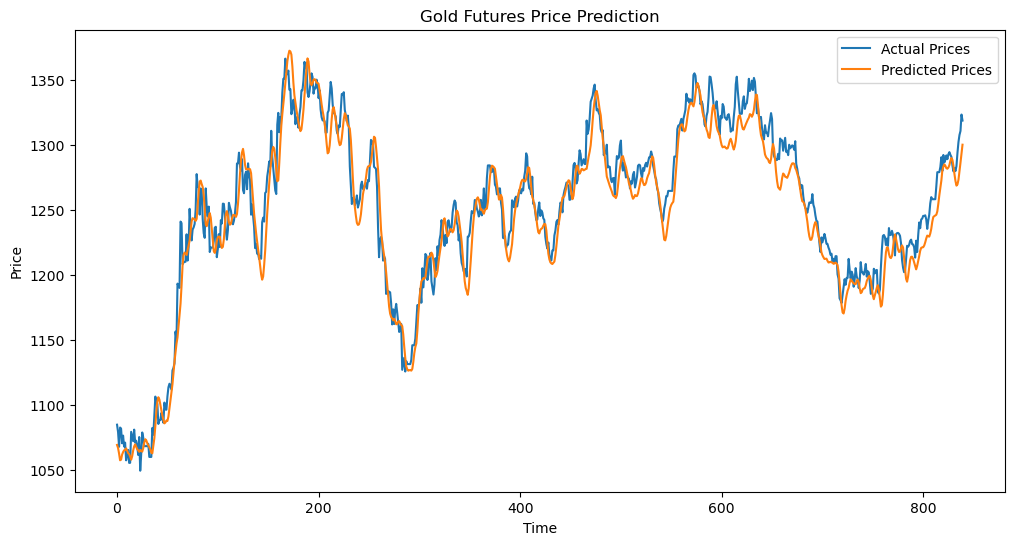

In [ ]:
# Run the hyperparameter tuning workflow
best_model, results = hyperparameter_tuning_workflow(
    data=load_data(), 
    seq_length=60,
    features=['Price', 'DXY', 'DFII10', 'VIX', 'CPI', 'Sentiment_Score', 'Exponential_Weighted_Score', 'EMA30', 'EMA252', 'RSI', 'Band_Spread'] 
)

## All features

In [12]:
def analyze_feature_importance(model, price_scaler, X_test, y_test, feature_names, 
                              batch_size=None, 
                              n_repeats=5,
                              normalize=True,
                              show_plot=True,
                              figure_size=(12, 6),
                              sort_features=False):
    """
    Analyze feature importance using timestep-aware permutation for sequential models.
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    
    # Get baseline predictions and baseline MSE
    baseline_preds = model.predict(X_test, batch_size=batch_size, verbose=0)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # Initialize arrays to store results
    n_features = X_test.shape[2]
    importances = np.zeros((n_repeats, n_features))
    
    # For each feature
    for i in range(n_features):
        # For each repetition
        for r in range(n_repeats):
            # Create a copy of the test data
            X_permuted = X_test.copy()
            
            # Permute feature values per timestep to maintain sequential structure
            # (Works for both LSTM and Transformer)
            for t in range(X_permuted.shape[1]):  # Loop over timesteps
                X_permuted[:, t, i] = np.random.permutation(X_permuted[:, t, i])
            
            # Get predictions with permuted feature
            permuted_preds = model.predict(X_permuted, batch_size=batch_size, verbose=0)
            permuted_mse = mean_squared_error(y_test, permuted_preds)
            
            # Calculate importance: how much the performance drops due to permutation
            # Higher value = more important feature
            importances[r, i] = permuted_mse - baseline_mse
    
    # Calculate mean and std of importance scores across repetitions
    mean_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)
    
    # Force non-negative importance values (some might be negative due to randomness)
    mean_importances = np.maximum(0, mean_importances)
    
    # Normalize if requested and possible
    if normalize and np.sum(mean_importances) > 0:
        mean_importances = mean_importances / np.sum(mean_importances)
    
    # Prepare data for plotting
    if sort_features:
        # Sort features by importance
        sorted_idx = np.argsort(mean_importances)[::-1]  # Descending order
        plot_features = [feature_names[i] for i in sorted_idx]
        plot_importances = mean_importances[sorted_idx]
        plot_stds = std_importances[sorted_idx]
    else:
        plot_features = feature_names
        plot_importances = mean_importances
        plot_stds = std_importances
    
    # Plot feature importance
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figure_size)

        # Plot predictions (last 100)
        ax1.plot(price_scaler.inverse_transform(y_test[-100:].reshape(-1, 1)), label="True", color="blue")
        ax1.plot(price_scaler.inverse_transform(baseline_preds[-100:]), label="Predicted", color="red")
        ax1.set_title("Last 100 Predictions vs True Values")
        ax1.set_xlabel("Time Step")
        ax1.set_ylabel("Value")
        ax1.legend()
        ax1.grid(True)

        # Plot feature importances
        bars = ax2.bar(range(len(plot_features)), plot_importances, yerr=plot_stds,
                       align='center', alpha=0.8, ecolor='black', capsize=5)
        ax2.set_xlabel("Features")
        ax2.set_ylabel("Relative Importance")
        ax2.set_title("Feature Importance (Timestep-Aware Permutation)")
        ax2.set_xticks(range(len(plot_features)))
        ax2.set_xticklabels(plot_features, rotation=45, ha='right')

        # Add text labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
    
    # Return results as a dictionary
    results = {
        'mean_importance': dict(zip(feature_names, mean_importances)),
        'std_importance': dict(zip(feature_names, std_importances)),
        'baseline_error': baseline_mse,
        'method': 'timestep_aware'
    }
    
    return results

Reloading Tuner from keras_tuner_dir/lstm_hyperparams/tuner0.json
Best hyperparameters:
num_lstm_layers: 3
lstm_units_0: 256
dense_units: 64
l2_reg: 0.0002358967174098809
dropout_rate: 0.5
learning_rate: 0.007009223137181971
lstm_units_1: 32
lstm_units_2: 32
Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.1673 - root_mean_squared_error: 0.3724 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0277 - learning_rate: 0.0070
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0161 - root_mean_squared_error: 0.0857 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0482 - learning_rate: 0.0070
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0128 - root_mean_squared_error: 0.0731 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0308 - learning_rate: 0.0070
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0105 - root_mean_squared_error: 0.0637 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0566 - learning_rate: 0.0070
Epoch 5/40
83/83 

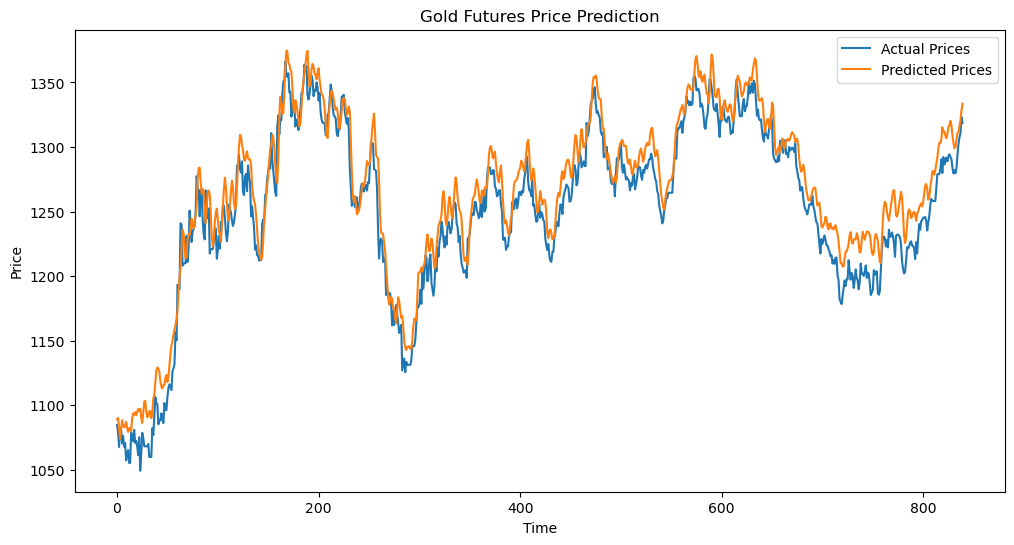

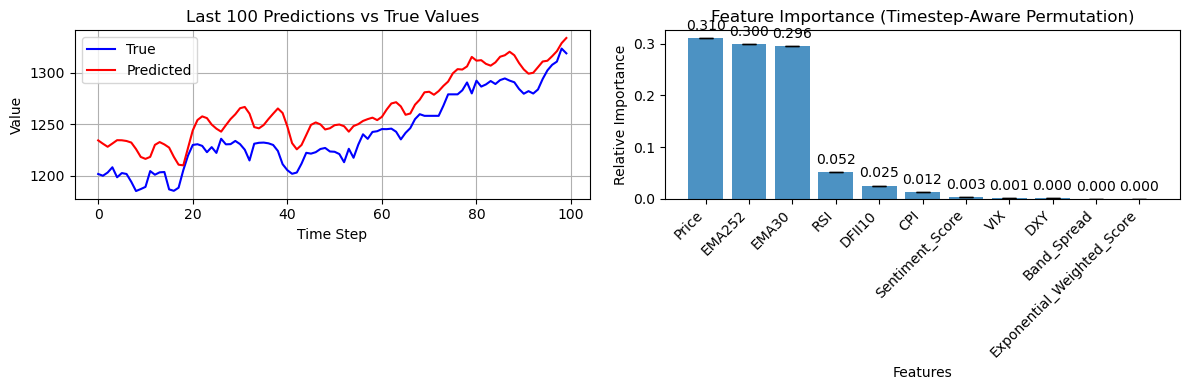

In [20]:
def hyperparameter_tuning_workflow(data, seq_length=60, features=["Price"]):
    """
    Complete workflow for hyperparameter tuning and model training.
    
    Parameters:
        data: Input DataFrame
        seq_length: Length of sequence for LSTM
        features: List of feature columns to use
        
    Returns:
        tuple: (best model, evaluation results)
    """
    data = data[features]

    # Prepare data
    test_size = 0.2
    # Split raw data first
    train_size = int(len(data) * (1 - test_size))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size - seq_length:]
    train_data, scaler_dict, features = prepare_data(train_data, features)
    price_scaler = scaler_dict['Price']

    # Apply the same scalers to test data
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )

    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)

    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters
    best_hps, best_model = tune_hyperparameters(X_train, y_train, input_shape)
    
    # Train the best model
    history = train_best_model(best_model, X_train, y_train)
    
    # Evaluate the model
    target_col = features.index("Price") if "Price" in features else 0
    
    results, mape, mse, rmse, directional_accuracy, r2, mae = evaluate_model(best_model, X_test, y_test, price_scaler, target_col)
    
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    print(f"R squared: {r2:.2f}")
    
    # Plot results
    plot_results(results['actual'], results['pred'])

    analyze_feature_importance(best_model, price_scaler, X_test, y_test, features, 
                              batch_size=None, 
                              n_repeats=5,
                              normalize=True,
                              show_plot=True,
                              figure_size=(12, 4),
                              sort_features=True)


    
    return data, best_model, results

# Run the hyperparameter tuning workflow
data, best_model, results = hyperparameter_tuning_workflow(
    data=load_data(), 
    seq_length=60,
    features=['Price', 'DXY', 'DFII10', 'VIX', 'CPI', 'Sentiment_Score', 'Exponential_Weighted_Score', 'EMA30', 'EMA252', 'RSI', 'Band_Spread'] 
)


In [41]:
test_dates = data.index[-len(results['actual']):]
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual": np.array(results['actual']).flatten(),
    "Predicted": np.array(results['pred']).flatten()
})
import pickle
with open("lstm_results.pkl", "wb") as f:
    pickle.dump(comparison_df, f)

In [42]:
import pickle
with open("lstm_results.pkl", "rb") as f:
    loaded_df = pickle.load(f)
print(loaded_df)

          Date  Actual    Predicted
0   2015-11-16  1084.8  1076.059082
1   2015-11-17  1079.2  1077.100464
2   2015-11-18  1067.8  1067.720703
3   2015-11-19  1082.6  1063.093018
4   2015-11-20  1081.8  1070.073853
..         ...     ...          ...
835 2019-01-28  1302.2  1282.132812
836 2019-01-29  1307.6  1289.211304
837 2019-01-30  1310.7  1295.366943
838 2019-01-31  1323.3  1305.985840
839 2019-02-01  1318.7  1309.440674

[840 rows x 3 columns]


In [15]:
best_model.save("LSTM_all_features_model.h5")

## Price only

In [ ]:
def hyperparameter_tuning_workflow(data, seq_length=60, features=["Price"]):
    """
    Complete workflow for hyperparameter tuning and model training.
    
    Parameters:
        data: Input DataFrame
        seq_length: Length of sequence for LSTM
        features: List of feature columns to use
        
    Returns:
        tuple: (best model, evaluation results)
    """
    data = data[features]

    # Prepare data
    test_size = 0.2
    # Split raw data first
    train_size = int(len(data) * (1 - test_size))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size - seq_length:]
    train_data, scaler_dict, features = prepare_data(train_data, features)
    price_scaler = scaler_dict['Price']

    # Apply the same scalers to test data
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )

    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters
    best_hps, best_model = tune_hyperparameters(X_train, y_train, input_shape)
    
    # Train the best model
    history = train_best_model(best_model, X_train, y_train)
    
    # Evaluate the model
    target_col = features.index("Price") if "Price" in features else 0
    
    results, mape, mse, rmse, directional_accuracy, r2, mae = evaluate_model(best_model, X_test, y_test, price_scaler, target_col)
    
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    print(f"R squared: {r2:.2f}")
    
    # Plot results
    plot_results(results['actual'], results['pred'])
    
    return data, best_model, results

# Run the hyperparameter tuning workflow
data, best_model, results = hyperparameter_tuning_workflow(
    data=load_data(), 
    seq_length=60,
    features=['Price'] 
)


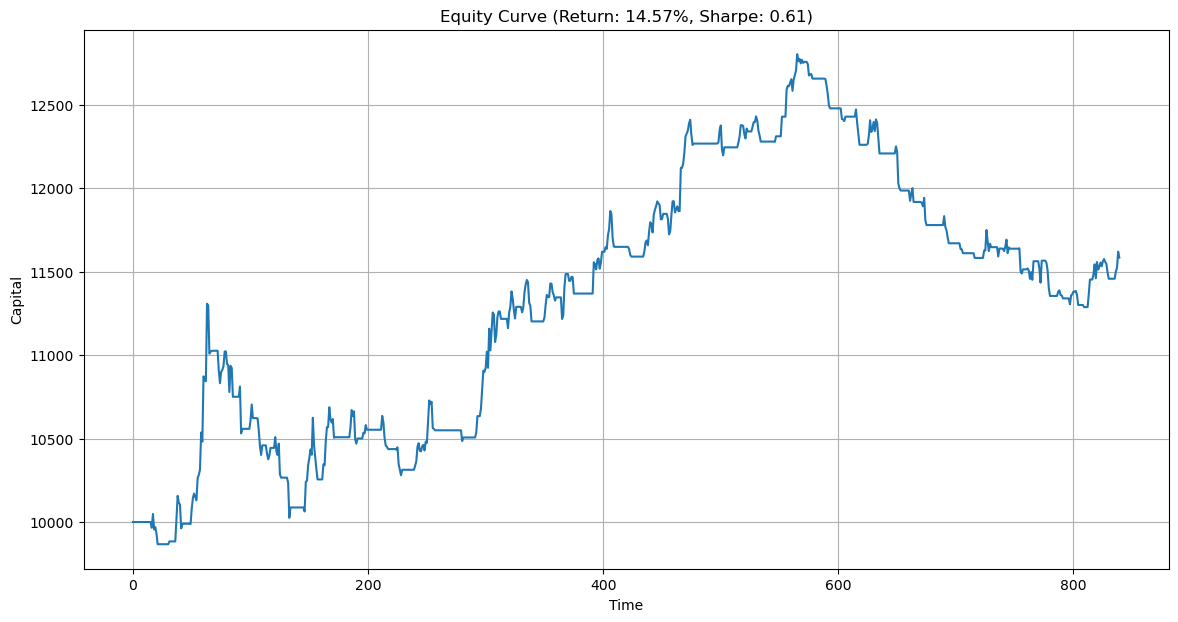

Final capital: $11457.16
Return: 14.57%
Sharpe Ratio: 0.61
Number of trades: 60


In [18]:
trades, equity_curve = backtest_trading_strategy(results["actual"], results["pred"])